## Критерий останова построения дерева

Для любой непротиворечивой обучающей выборки можно построить решающее дерево, которое имеет нулевую ошибку на данной выборке. Если мы рассмотрим объекты, как точки в пространстве признаков, то каждую эту точку можно ограничить n-мерным кубиком, который не будет содержать других точек. n-мерный кубик прекрасно можно задать деревом.

 Однако в этом случае имеет место **переобучение**. 

В связи с этим встаёт вопрос: в каком случае вершину следует объявить листовой?

Рассмотрим модельную задачу регрессии. Объектами будут являться точки на плоскости (т.е. каждый объект описывается 2 признаками), целевой переменной — расстояние от объекта до точки (0, 0).

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import pylab as plt


Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

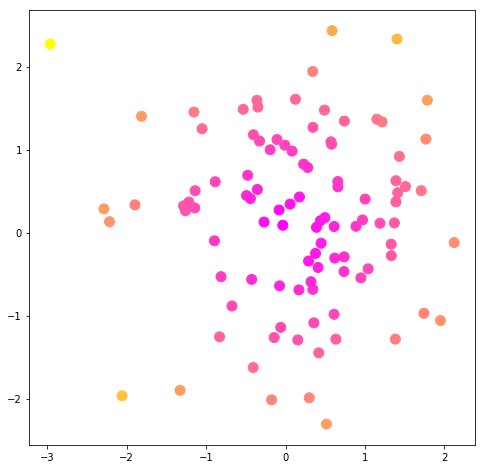

In [3]:
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')

In [4]:
from sklearn.tree import DecisionTreeRegressor

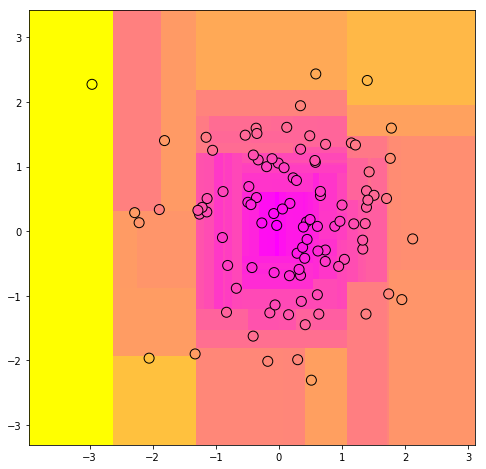

In [5]:
clf = DecisionTreeRegressor()
clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring', edgecolor='k')

Посмотрим как будет выглядить разделение плоскости в зависимости от 
- минимального количества объектов в листе
- максимальной глубины дерева

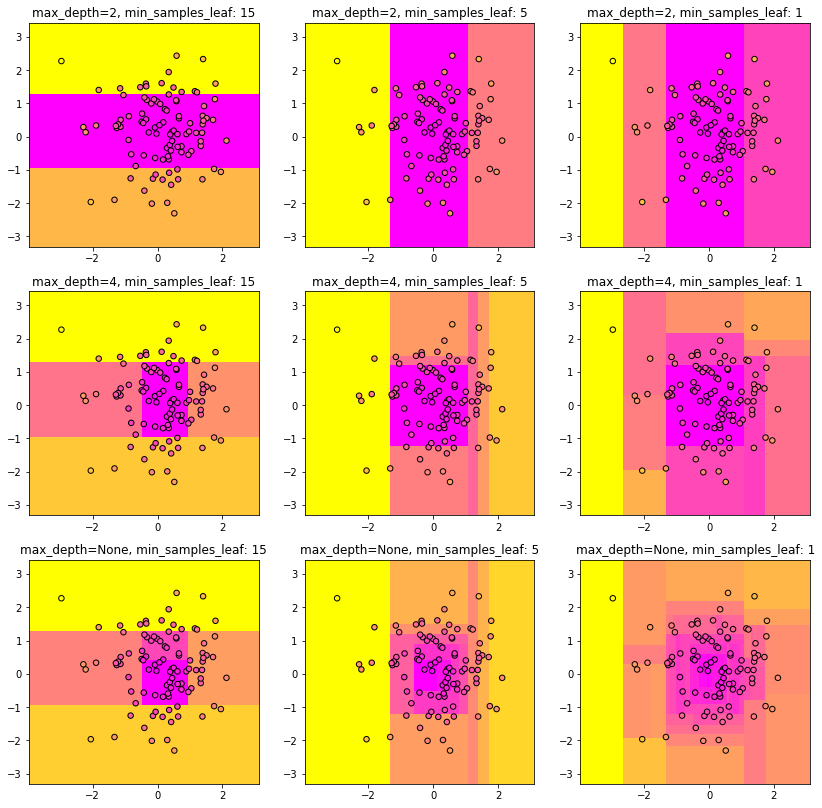

In [6]:
plt.figure(figsize=(14, 14))
for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='spring')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='spring', edgecolor='k')
        plt.title('max_depth=' + str(max_depth) + ', min_samples_leaf: ' + str(min_samples_leaf))

- Увеличение максимальной глубины и/или уменьшение минимального количества объектов выборки в листе приводит к увеличению качества на обучающей выборке и переобучению.

## Неустойчивость решающих деревьев

Решающие деревья — это алгоритмы, неустойчивые к изменениям обучающей выборки, т.е. при малейших её изменениях итоговый классификатор может радикально измениться.
Посмотрим, как будет меняться структура дерева при обучении на разных 90%-х подвыборках.


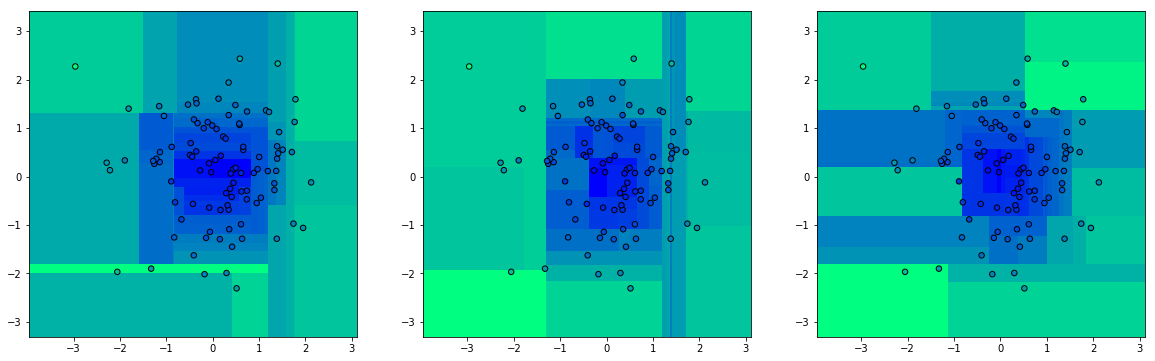

In [7]:
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeRegressor(random_state=42)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter', edgecolor='k')

## Подбор параметров

Посмотрим на качество дерева в зависимости от параметров на одном из стандартных наборов данных - Бостонском датасете.

Загрузим датасет и посмотрим на него.

In [8]:
from sklearn.datasets import load_boston

In [9]:
data = load_boston()
data.DESCR

"Boston House Prices dataset\n===========================\n\nNotes\n------\nData Set Characteristics:  \n\n    :Number of Instances: 506 \n\n    :Number of Attributes: 13 numeric/categorical predictive\n    \n    :Median Value (attribute 14) is usually the target\n\n    :Attribute Information (in order):\n        - CRIM     per capita crime rate by town\n        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.\n        - INDUS    proportion of non-retail business acres per town\n        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)\n        - NOX      nitric oxides concentration (parts per 10 million)\n        - RM       average number of rooms per dwelling\n        - AGE      proportion of owner-occupied units built prior to 1940\n        - DIS      weighted distances to five Boston employment centres\n        - RAD      index of accessibility to radial highways\n        - TAX      full-value property-tax rate per $10,000\n

In [10]:
X = data.data
y = data.target

In [11]:
X.shape

(506, 13)

In [12]:
y[:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

Сделаем разбиения для кросс-валидации

In [13]:
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(shuffle=True, random_state=241)

Обучим обычное дерево

In [14]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(random_state=241)
-cross_val_score(regr, X, y, cv=cv, 
                 scoring='neg_mean_squared_error').mean()

26.003519888231427

In [15]:
regr.fit(X, y)
regr.tree_

In [16]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(random_state=241)
cross_val_score(regr, X, y, cv=cv, 
                scoring='r2').mean()

0.6890163483498611

Теперь переберем разные параметры для дерева

In [17]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(DecisionTreeRegressor(random_state=241),
                  param_grid={'max_features': [None, 'log2', 'sqrt'], 
                              'max_depth': [2, 4, 6, 8, 10, 20, 50]},
                  cv=cv,
                  scoring='r2')
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=241, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=241, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 'log2', 'sqrt'], 'max_depth': [2, 4, 6, 8, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [18]:
pd.DataFrame(gs.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py

,params,mean_test_score,std_test_score
0,"{'max_depth': 2, 'max_features': None}",0.646564,0.044402
1,"{'max_depth': 2, 'max_features': 'log2'}",0.394939,0.042090
2,"{'max_depth': 2, 'max_features': 'sqrt'}",0.394939,0.042090
3,"{'max_depth': 4, 'max_features': None}",0.695231,0.109133
4,"{'max_depth': 4, 'max_features': 'log2'}",0.514569,0.166457
5,"{'max_depth': 4, 'max_features': 'sqrt'}",0.514569,0.166457
6,"{'max_depth': 6, 'max_features': None}",0.727279,0.068206
7,"{'max_depth': 6, 'max_features': 'log2'}",0.623824,0.024930
8,"{'max_depth': 6, 'max_features': 'sqrt'}",0.623824,0.024930
9,"{'max_depth': 8, 'max_features': None}",0.704835,0.085594


In [19]:
gs.best_score_

0.727279335978877

In [20]:
gs.best_params_

{'max_depth': 6, 'max_features': None}

## Решающие леса

Чтобы уменьшить влияние рассмотренных недостатков решающих деревьев, используют **случайные леса (random forest)**. Одно дерево может ошибаться, поэтому давайте построим много деревьев и "усредним" их ответы.

Если строить все эти леса по одной и той же обучающей выборке, они будут одинаковые, поэтому для каждого решающего дерева, которое мы строим:
* вместо исходной обучающей выборки $X$ используется бутстрап (т.е. выборка $l$ объектов **с возвращениями**);
* в каждой внутренней вершине выбор условия осуществляется не среди всех признаков, а среди $q$ случайно выбранных.

Такая рандомизация обеспечит нам различность деревьев. После того, как таким образом были получены алгоритмы $b_1(x), ... b_N(x)$ можно построить итоговый алгоритм как:
* **выбор большинства** в случае классификации: $a(x) = \arg \max_{y \in \mathbb{Y}} \sum_{n=1}^N [b_n(x) = y]$
* **среднее** в случае регрессии: $a(x) = \frac{1}{N} \sum_{n = 1}^N b_n(x)$

Для начала посмотрим, как выглядит разделение плоскости для случайного леса на модельной задаче.

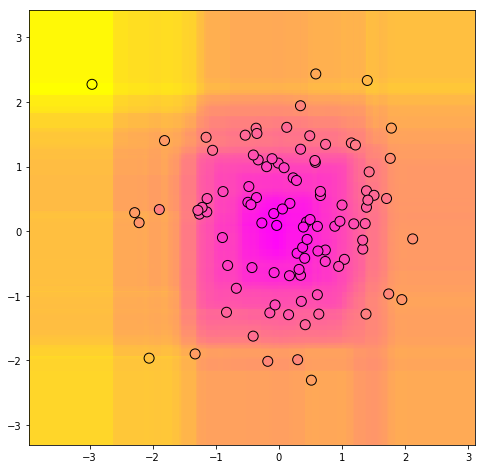

In [21]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100)
clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring', edgecolor='k')

Видно, что в целом переходы гораздо более плавные.

Теперь вернемся к Бостонскому датасету и посмотрим, какое качество можно получить при использовании различных способов усреднения деревьев.

Обычное решающее дерево

In [22]:
regr = DecisionTreeRegressor()
print(cross_val_score(regr, X, y, cv=cv,
                      scoring='r2').mean())

0.6842467895304342


Бутстрап с разными параметрами (количество деревьев и размер подвыборки)

In [23]:
from sklearn.ensemble import BaggingRegressor

In [24]:
regr = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10,
                        bootstrap=False, random_state=241)
print(cross_val_score(regr, X, y, cv=cv,
                      scoring='r2').mean())

0.7253397213164771


In [25]:
regr = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10,
                        bootstrap=False, random_state=241,
                        max_samples=0.707)
print(cross_val_score(regr, X, y, cv=cv,
                      scoring='r2').mean())

0.8171972900100748


In [26]:
regr = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100,
                        bootstrap=False, random_state=241,
                        max_samples=0.5)
print(cross_val_score(regr, X, y, cv=cv,
                      scoring='r2').mean())

0.8185866739660482


In [27]:
regr = BaggingRegressor(DecisionTreeRegressor(), n_estimators=1000,
                        bootstrap=False, random_state=241,
                        max_samples=0.5)
print(cross_val_score(regr, X, y, cv=cv,
                      scoring='r2').mean())

0.8240558184641174


Случайный лес с разными параметрами

In [28]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=10)
print(cross_val_score(regr, X, y, cv=cv,
                      scoring='r2').mean())

0.8182768164965508


In [29]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=100)
print(cross_val_score(regr, X, y, cv=cv,
                      scoring='r2').mean())

0.8305857817889951


In [30]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=300)
print(cross_val_score(regr, X, y, cv=cv,
                      scoring='r2').mean())

0.8287060915480606


In [31]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=500)
print(cross_val_score(regr, X, y, cv=cv,
                      scoring='r2').mean())

0.8258157285075169


In [32]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=1000)
print(cross_val_score(regr, X, y, cv=cv,
                      scoring='r2').mean())

0.82982665115922


### Probability calibration

Калибровка вероятностей - приведение ответов алгоритма к значениям, близким к вероятностям объектов принадлежать конкретному классу.

Зачем это нужно? 
- Вероятности гораздо проще интерпретировать
- Вероятности могут дать дополнительную информацию о результатах работы алгоритма

Для каких алгоритмов стоит калибровать вероятности?
- SVM Classifier?
- Logistic Regression?
- Random Forest?

### Методы калибровки

Для чего нужна калибровка? Допустим, у нас есть алгоритм, который решает задачу классификации. При этом он выдает предсказания не в виде меток классов, а в виде значений в промежутке $[0,1]$. При этом чем больше значение предсказания на данном объекте, тем больше шансов, что он принадлежит первому классу. Мы хотим из этих предсказаний получить настоящие оценки вероятностей.

Идея калибровки заключаются в следующем: на отложенной выборке настроим **монотонную** регрессию по предсказаниям классфикатора на метки классов. Эта регрессия будет обучаться примерно на таких данных: если на наборе объектов получается одинаковое предсказание $q$, и среди этих объектов доля объекта положительного класса равна $p$, то регрессия должна отобразить $q$ в $p$ (на самом деле все чуть сложнее, но мы это разбирать не будем). Соответствующая построенная модель, применённая к предсказаниям алгоритма, и будет откалиброванными предсказаниями алгоритма.

Регрессия называется монотонной, если $x_i < x_j \rightarrow f(x_i) < f(x_j)$

Предлагаятся два варианта калибровки(два способа построения регрессии):
- isotonic
Непараметрический метод, который настраивает кусочно-постоянную неубывающую функцию (калибрует хорошо, но имеет тенденцию к переобучению при маленькой калибрационной выборке)
- sigmoid
 $$P(y=1|x)=(1+\exp(Af(x)+B))^{-1}$$
 где коэффициенты A и B настраиваются.


Сгененируем некоторые данные для примера

In [33]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [34]:
r = np.random.randn(30000,2)
r1 = np.random.randn(30000,2) + np.array([5,5])
r2 = np.random.randn(30000,2) + np.array([-5,-5])

In [35]:
r0 = np.vstack((r, r1, r2))
y0 = np.concatenate((np.zeros(30000), (np.random.uniform(0,1, size =30000) > 0.5).astype(int),
                    np.ones(30000)))

In [36]:
import matplotlib.pyplot as plt

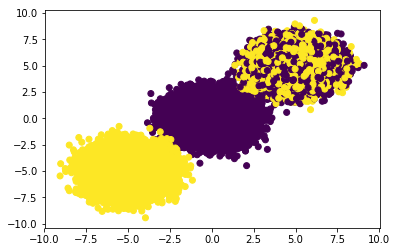

In [37]:
plt.scatter(r0[:,0], r0[:,1], c = y0)

Настроим классификатор и посмотрим на его вероятности до калибровки. Для этого построим 1) график отсортированных предсказаний вероятностей, 2) среднее значение положительных ответов для каждого значения предсказания вероятности. В идеале в (1) должно быть примерно треть значений 0%, еще треть 50% и треть 100% (см. график), а в (2) должна быть прямая y=x.

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
Xtr, Xt, ytr, yt = train_test_split(r0, y0, train_size=10000)
rf = RandomForestClassifier(n_estimators=100).fit(Xtr, ytr)


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Text(0.5,1,'Calibration plots  (reliability curve)')

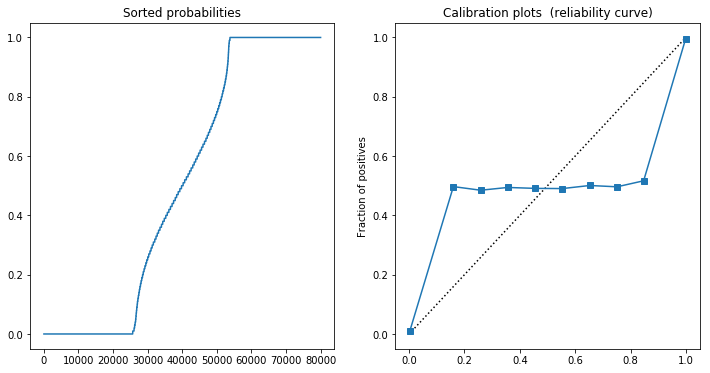

In [39]:
plt.figure(figsize=(12, 6))
ax1 = plt.subplot2grid((1, 2), (0, 0))
prob_pos = rf.predict_proba(Xt)[:, 1]
ax1.plot(np.sort(prob_pos))
ax1.set_title("Sorted probabilities")

ax2 = plt.subplot2grid((1, 2), (0, 1))
ax2.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives, mean_predicted_value = \
            calibration_curve(yt, prob_pos, n_bins=10)
ax2.plot(mean_predicted_value, fraction_of_positives, "s-")

ax2.set_ylabel("Fraction of positives")
ax2.set_ylim([-0.05, 1.05])
ax2.set_title('Calibration plots  (reliability curve)')

Теперь откалибруем вероятности и посмотрим на результат

In [40]:
crf = CalibratedClassifierCV(RandomForestClassifier(n_estimators=100), method='isotonic')
crf = crf.fit(Xtr,ytr)

Text(0.5,1,'Calibration plots  (reliability curve)')

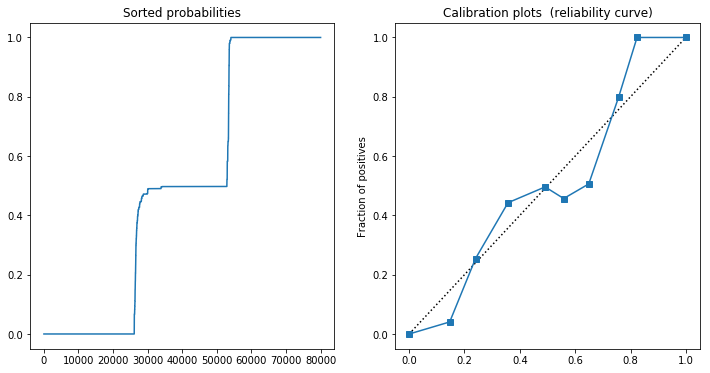

In [41]:
plt.figure(figsize=(12, 6))
ax1 = plt.subplot2grid((1, 2), (0, 0))
prob_pos = crf.predict_proba(Xt)[:, 1]
ax1.plot(np.sort(prob_pos))
ax1.set_title("Sorted probabilities")

ax2 = plt.subplot2grid((1, 2), (0, 1))
ax2.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives, mean_predicted_value = \
            calibration_curve(yt, prob_pos, n_bins=10)
ax2.plot(mean_predicted_value, fraction_of_positives, "s-")

ax2.set_ylabel("Fraction of positives")
ax2.set_ylim([-0.05, 1.05])
ax2.set_title('Calibration plots  (reliability curve)')

Теперь аналогичный пример для многомерных данных.

In [42]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, 
                           n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=4, class_sep=0.5,
                           random_state=12)

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

Xtr, Xt, ytr, yt = train_test_split(X, y, train_size = 2000)
rf = RandomForestClassifier(n_estimators=100).fit(Xtr, ytr)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Text(0.5,1,'Calibration plots  (reliability curve)')

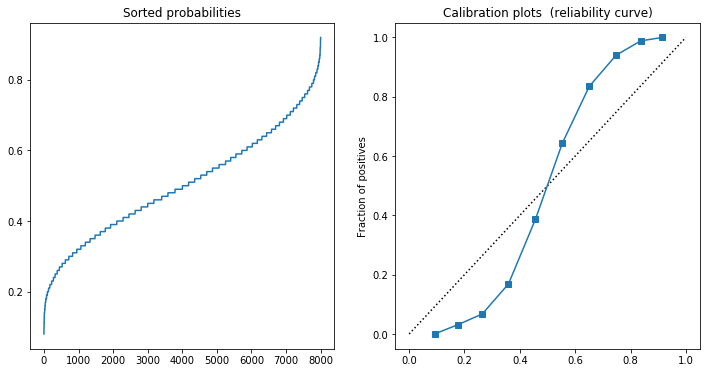

In [44]:
plt.figure(figsize=(12, 6))
ax1 = plt.subplot2grid((1, 2), (0, 0))
prob_pos = rf.predict_proba(Xt)[:, 1]
ax1.plot(np.sort(prob_pos))
ax1.set_title("Sorted probabilities")

ax2 = plt.subplot2grid((1, 2), (0, 1))
ax2.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives, mean_predicted_value = \
            calibration_curve(yt, prob_pos, n_bins=10)
ax2.plot(mean_predicted_value, fraction_of_positives, "s-")

ax2.set_ylabel("Fraction of positives")
ax2.set_ylim([-0.05, 1.05])
ax2.set_title('Calibration plots  (reliability curve)')

In [45]:
crf = CalibratedClassifierCV(rf, method='isotonic')
crf = crf.fit(Xtr,ytr)

Text(0.5,1,'Calibration plots  (reliability curve)')

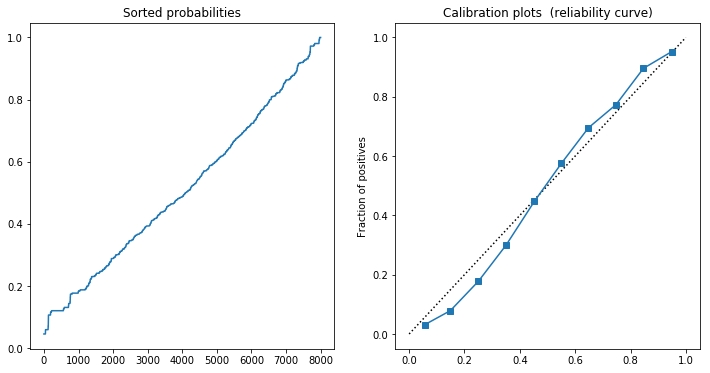

In [46]:
plt.figure(figsize=(12, 6))
ax1 = plt.subplot2grid((1, 2), (0, 0))
prob_pos = crf.predict_proba(Xt)[:, 1]
ax1.plot(np.sort(prob_pos))
ax1.set_title("Sorted probabilities")

ax2 = plt.subplot2grid((1, 2), (0, 1))
ax2.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives, mean_predicted_value = \
            calibration_curve(yt, prob_pos, n_bins=10)
ax2.plot(mean_predicted_value, fraction_of_positives, "s-")

ax2.set_ylabel("Fraction of positives")
ax2.set_ylim([-0.05, 1.05])
ax2.set_title('Calibration plots  (reliability curve)')

[Еще примеры](http://scikit-learn.org/stable/modules/calibration.html)